In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils import resample
from sklearn.linear_model import SGDClassifier
from gensim.models import Word2Vec

In [2]:
# Specify the data types for each column
dtype_dict = {
    'review_id': 'object',
    'review_text': 'object',
    'upvotes': 'int64',
    'app_version': 'object',
    'posted_date': 'object'
}

# Read the CSV file with the specified data types and low_memory set to False
df = pd.read_csv('./tiktok_app_reviews.csv', dtype=dtype_dict, low_memory=False)

# Print the first few rows to verify
print(df.head())


                                           review_id  \
0  gp:AOqpTOGSsGv5rOA79ttW2LE0FeMYvkdUuXRMTfbyMk0...   
1  gp:AOqpTOEDQ9__FJihY_0V4iwqy4P2OK8tGVR1tFBixYb...   
2  gp:AOqpTOEGEfr8TL0iKTlpbTDeM8P7HywlMmP9CkHMoaT...   
3  gp:AOqpTOGZBDl9dpghmb43Mx1tnlWCOjNXyuVn5Mxf49c...   
4  gp:AOqpTOFioH3wud_JnC4aPCG4p7s5DEEN2yZAWNXdRJj...   

                                         review_text  upvotes app_version  \
0  It is an excellent solution to finding videos ...      402      21.2.5   
1  Great app works really well so many features s...       67      21.2.5   
2  I down loaded app but didnt work . i love this...       24      21.2.5   
3  IT A GREAT APP AND FUN TO USE! HOWEVER ARBITRA...       18      21.2.5   
4  Currently it's working good for me except a fe...      232     21.1.41   

           posted_date  
0  2021-09-20 07:50:23  
1  2021-09-19 23:10:47  
2  2021-09-19 08:59:34  
3  2021-09-19 16:34:43  
4  2021-09-14 06:35:02  


In [3]:
# Get the total number of observations (rows)
total_observations = len(df)
total_observations

3646476

In [4]:
# Check for missing values
print(df.isnull().sum())

review_id           0
review_text       163
upvotes             0
app_version    993269
posted_date         0
dtype: int64


In [5]:
# Drop rows with missing review_text
df.dropna(subset=['review_text'], inplace=True)

In [6]:
# Optionally, fill missing app_version with a placeholder 
df['app_version'].fillna('unknown', inplace=True)

In [7]:
# Check for missing values
print(df.isnull().sum())

review_id      0
review_text    0
upvotes        0
app_version    0
posted_date    0
dtype: int64


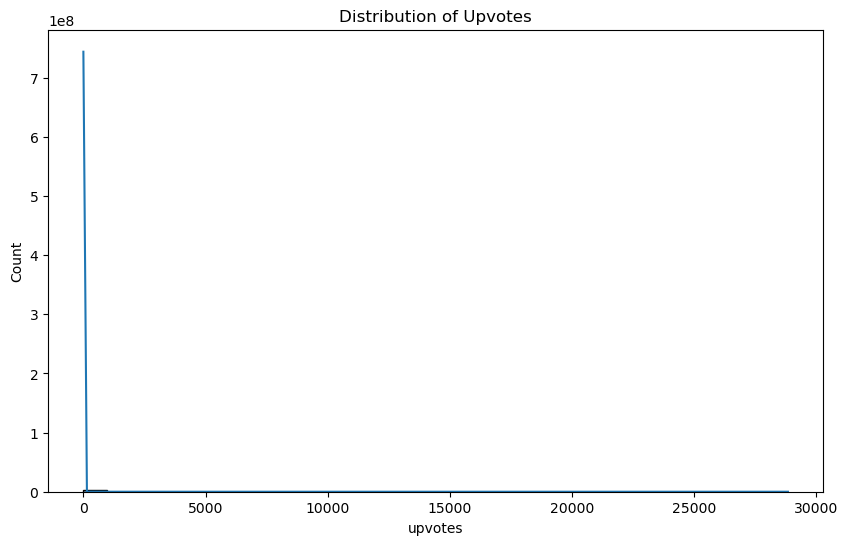

In [8]:
# Distribution of upvotes
plt.figure(figsize=(10, 6))
sns.histplot(df['upvotes'], bins=30, kde=True)
plt.title('Distribution of Upvotes')
plt.show()

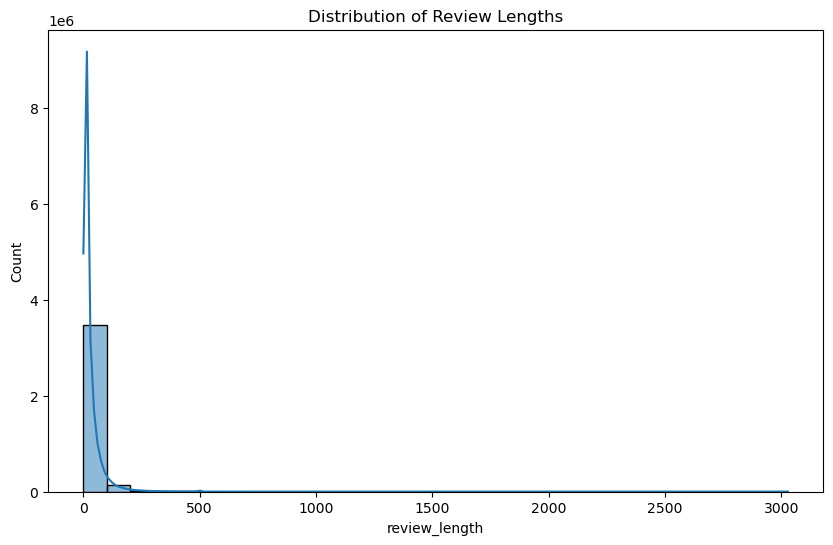

In [9]:
# Reviews length distribution
df['review_length'] = df['review_text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], bins=30, kde=True)
plt.title('Distribution of Review Lengths')
plt.show()

In [10]:
# Convert posted_date to datetime
df['posted_date'] = pd.to_datetime(df['posted_date'])
df['year'] = df['posted_date'].dt.year
df['month'] = df['posted_date'].dt.month


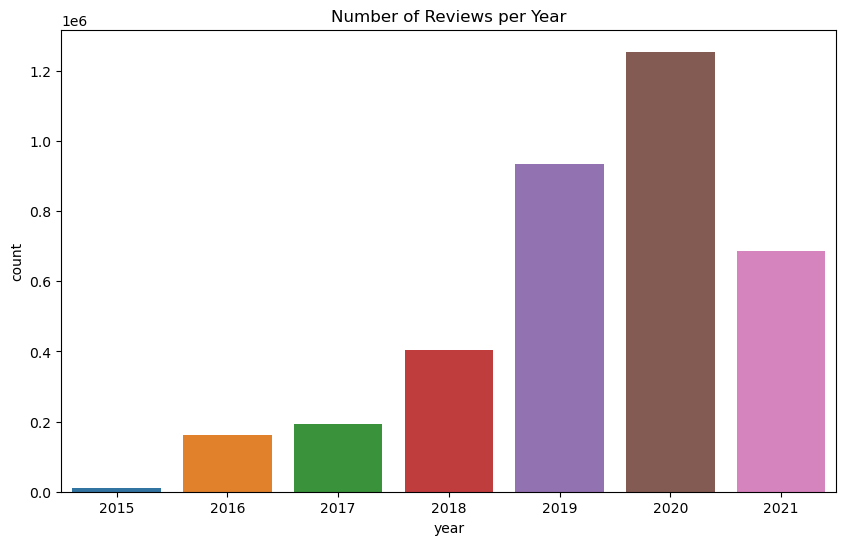

In [11]:
# Number of reviews per year
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='year')
plt.title('Number of Reviews per Year')
plt.show()

In [12]:
# Subsample the data
subset_df = df.sample(frac=0.1, random_state=1)  # Using 5% of the data


In [13]:
# Preprocessing function to clean text data
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    return text


In [14]:
# Apply preprocessing to the review text
subset_df['cleaned_review_text'] = subset_df['review_text'].apply(preprocess_text)

In [15]:
# Calculate the median upvotes on the subset
median_upvotes = subset_df['upvotes'].median()

In [16]:
# Create a binary feature indicating if upvotes are above median
subset_df['above_median_upvotes'] = subset_df['upvotes'] > median_upvotes

In [17]:
# Balance the classes by resampling
minority_class = subset_df[subset_df['above_median_upvotes'] == 1]
majority_class = subset_df[subset_df['above_median_upvotes'] == 0]

In [18]:
# Upsample minority class
minority_upsampled = resample(minority_class,
                              replace=True,
                              n_samples=len(majority_class),
                              random_state=1)

# Combine majority class with upsampled minority class
balanced_df = pd.concat([majority_class, minority_upsampled])

# Check new class distribution
print(balanced_df['above_median_upvotes'].value_counts())

above_median_upvotes
False    350210
True     350210
Name: count, dtype: int64


In [19]:
# Apply preprocessing to the review text
balanced_df['cleaned_review_text'] = balanced_df['review_text'].apply(preprocess_text)

In [20]:
# Split the data into training and testing sets with stratified splitting
X_train, X_test, y_train, y_test = train_test_split(
    balanced_df['cleaned_review_text'],
    balanced_df['above_median_upvotes'],
    test_size=0.2,
    random_state=1,
    stratify=balanced_df['above_median_upvotes']
)

### SGDClassifier

In [21]:
# Create a pipeline with TF-IDF vectorizer and SGDClassifier
pipeline_sgd = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SGDClassifier(max_iter=1000, tol=1e-3))
])


In [22]:
# Define parameter grid for GridSearchCV
param_grid_sgd = {
    'tfidf__max_df': [0.8, 0.9],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__alpha': [0.0001, 0.001, 0.01]
}

In [23]:
# Perform GridSearchCV for SGDClassifier
grid_search_sgd = GridSearchCV(pipeline_sgd, param_grid_sgd, cv=3, n_jobs=-1, scoring='accuracy')
grid_search_sgd.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', SGDClassifier())]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.0001, 0.001, 0.01],
                         'tfidf__max_df': [0.8, 0.9],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy')

In [24]:
# Print the best parameters and score for SGDClassifier
print(f"Best Parameters for SGDClassifier: {grid_search_sgd.best_params_}")
print(f"Best Score for SGDClassifier: {grid_search_sgd.best_score_}")

Best Parameters for SGDClassifier: {'clf__alpha': 0.0001, 'tfidf__max_df': 0.8, 'tfidf__ngram_range': (1, 2)}
Best Score for SGDClassifier: 0.6796975406305386


In [25]:
# Predict on the test set for SGDClassifier
y_pred_sgd = grid_search_sgd.predict(X_test)

In [26]:
# Evaluate the model for SGDClassifier
print("SGDClassifier Classification Report:")
print(classification_report(y_test, y_pred_sgd))
print(f"SGDClassifier Accuracy Score: {accuracy_score(y_test, y_pred_sgd)}")

SGDClassifier Classification Report:
              precision    recall  f1-score   support

       False       0.64      0.83      0.72     70042
        True       0.76      0.53      0.63     70042

    accuracy                           0.68    140084
   macro avg       0.70      0.68      0.67    140084
weighted avg       0.70      0.68      0.67    140084

SGDClassifier Accuracy Score: 0.6818123411667285


### Random Forest and Gradient Boosting

In [27]:
# Subsample the data
subset_df1 = df.sample(frac=0.02, random_state=1)  # Using 2% of the data

In [28]:
# Preprocessing function to clean text data
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    return text

In [29]:
# Apply preprocessing to the review text
subset_df1['cleaned_review_text'] = subset_df1['review_text'].apply(preprocess_text)

In [30]:
# Calculate the median upvotes on the subset
median_upvotes = subset_df['upvotes'].median()

# Create a binary feature indicating if upvotes are above median
subset_df1['above_median_upvotes'] = subset_df1['upvotes'] > median_upvotes

# Balance the classes by resampling
minority_class = subset_df1[subset_df1['above_median_upvotes'] == 1]
majority_class = subset_df1[subset_df1['above_median_upvotes'] == 0]

In [31]:
# Upsample minority class
minority_upsampled = resample(minority_class,
                              replace=True,
                              n_samples=len(majority_class),
                              random_state=1)

# Combine majority class with upsampled minority class
balanced_df = pd.concat([majority_class, minority_upsampled])

In [32]:
# Split the data into training and testing sets with stratified splitting
X_train, X_test, y_train, y_test = train_test_split(
    balanced_df['cleaned_review_text'],
    balanced_df['above_median_upvotes'],
    test_size=0.2,
    random_state=1,
    stratify=balanced_df['above_median_upvotes']
)

In [33]:
# Define models to try
models = {
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier()
}


In [34]:
# Parameter grids for each model
param_grids = {
    'RandomForest': {
        'clf__n_estimators': [100, 200],
        'clf__max_depth': [10, 20],
        'clf__min_samples_split': [2, 5]
    },
    'GradientBoosting': {
        'clf__n_estimators': [100, 200],
        'clf__learning_rate': [0.01, 0.1],
        'clf__max_depth': [3, 5]
    }
}

best_model = None
best_score = 0
model_scores = {}
model_predictions = {}

In [35]:
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    # Create a pipeline with TF-IDF vectorizer and the current model
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', model)
    ])
    
    # Perform GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=StratifiedKFold(n_splits=3), n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Print the best parameters and score
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best Score for {model_name}: {grid_search.best_score_}")
    
    # Store the scores
    model_scores[model_name] = grid_search.best_score_
    
    # Store predictions
    model_predictions[model_name] = grid_search.predict(X_test)
    
    # Check if this model is the best so far
    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_model = grid_search

Training RandomForest...
Best Parameters for RandomForest: {'clf__max_depth': 20, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Best Score for RandomForest: 0.6908891386970719
Training GradientBoosting...


/Users/vinithshetty/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters for GradientBoosting: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 200}
Best Score for GradientBoosting: 0.723123316025195


In [36]:
# Predict on the test set using the best model
y_pred = best_model.predict(X_test)

In [37]:
# Evaluate the model
print("Best Model Classification Report:")
print(classification_report(y_test, y_pred))
print(f"Best Model Accuracy Score: {accuracy_score(y_test, y_pred)}")

Best Model Classification Report:
              precision    recall  f1-score   support

       False       0.67      0.86      0.76     14011
        True       0.81      0.58      0.68     14011

    accuracy                           0.72     28022
   macro avg       0.74      0.72      0.72     28022
weighted avg       0.74      0.72      0.72     28022

Best Model Accuracy Score: 0.7235743344515024


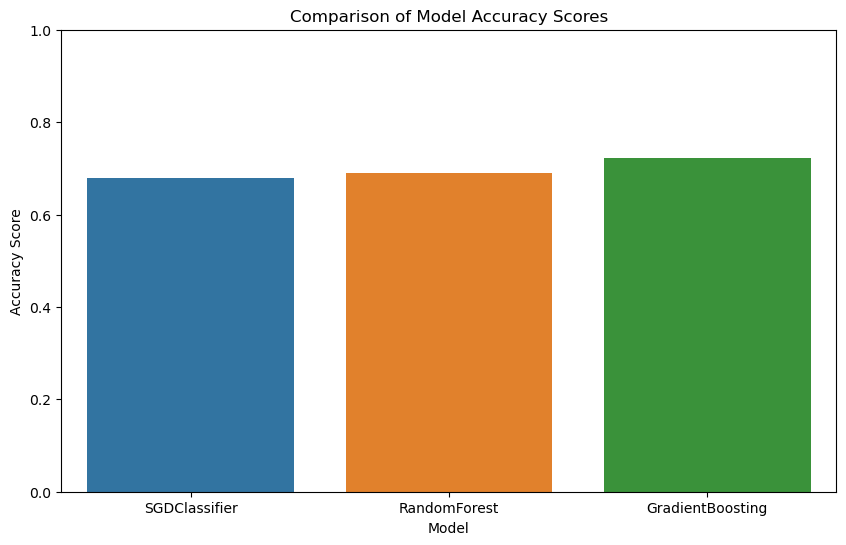

In [38]:
# Plot the comparison of model scores
plt.figure(figsize=(10, 6))
model_names = ['SGDClassifier', 'RandomForest', 'GradientBoosting']
model_accuracy = [grid_search_sgd.best_score_, model_scores['RandomForest'], model_scores['GradientBoosting']]

sns.barplot(x=model_names, y=model_accuracy)
plt.title('Comparison of Model Accuracy Scores')
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.ylim(0, 1)
plt.show()


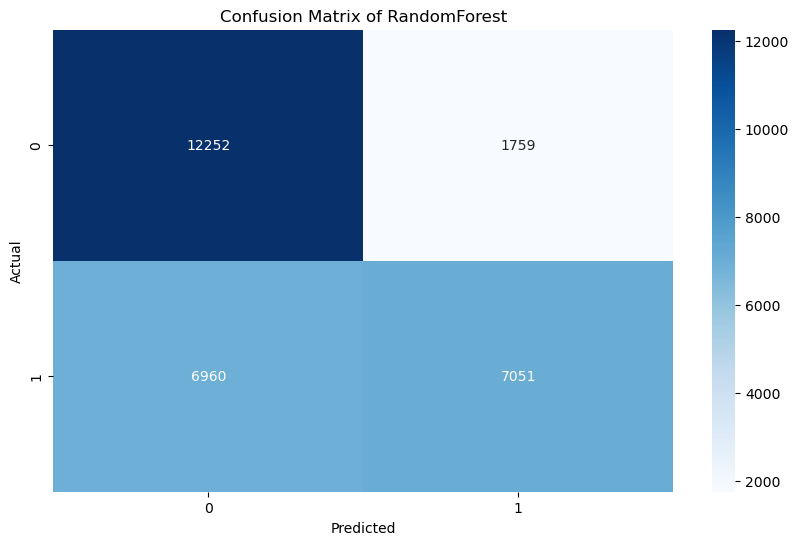

RandomForest Classification Report:
              precision    recall  f1-score   support

       False       0.64      0.87      0.74     14011
        True       0.80      0.50      0.62     14011

    accuracy                           0.69     28022
   macro avg       0.72      0.69      0.68     28022
weighted avg       0.72      0.69      0.68     28022

RandomForest Accuracy Score: 0.6888516165869674


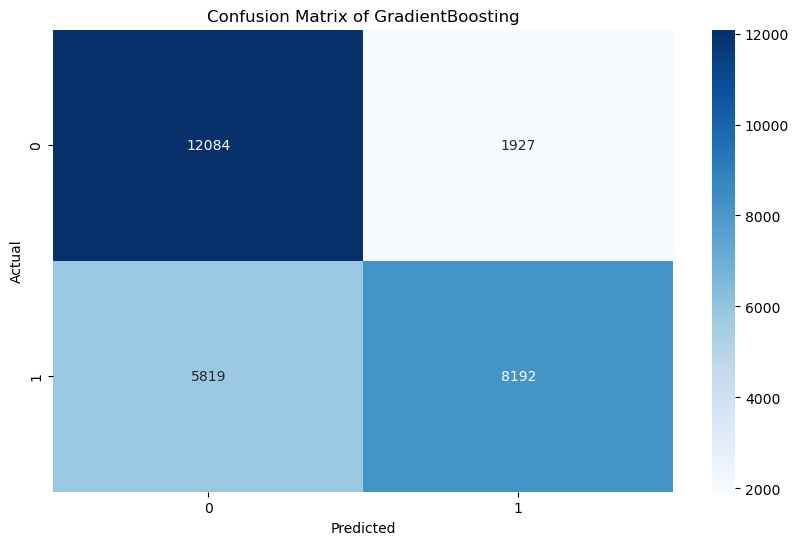

GradientBoosting Classification Report:
              precision    recall  f1-score   support

       False       0.67      0.86      0.76     14011
        True       0.81      0.58      0.68     14011

    accuracy                           0.72     28022
   macro avg       0.74      0.72      0.72     28022
weighted avg       0.74      0.72      0.72     28022

GradientBoosting Accuracy Score: 0.7235743344515024


In [39]:
# Confusion matrices for each model
for model_name, y_pred in model_predictions.items():
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix of {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"{model_name} Accuracy Score: {accuracy_score(y_test, y_pred)}")

#### Word2vec

In [40]:
# Subsample the data (using 5% of the data)
subset_df3 = df.sample(frac=0.05, random_state=1)

# Preprocess the text data
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    return text

In [41]:
# Apply preprocessing to the review text
subset_df3['cleaned_review_text'] = subset_df3['review_text'].apply(preprocess_text)

# Tokenize the text
subset_df3['tokenized_review_text'] = subset_df3['cleaned_review_text'].apply(lambda x: x.split())


In [42]:
# Train a Word2Vec model
word2vec_model = Word2Vec(sentences=subset_df3['tokenized_review_text'], vector_size=100, window=5, min_count=1, workers=4)

In [43]:
# Generate document embeddings by averaging word vectors
def get_avg_word2vec(text, model):
    words = [word for word in text if word in model.wv.key_to_index]
    if len(words) == 0:
        return np.zeros(model.vector_size)
    return np.mean(model.wv[words], axis=0)

subset_df3['word2vec_embedding'] = subset_df3['tokenized_review_text'].apply(lambda x: get_avg_word2vec(x, word2vec_model))

In [44]:
# Prepare the feature matrix
X = np.vstack(subset_df3['word2vec_embedding'].values)
median_upvotes = subset_df3['upvotes'].median()
subset_df3['above_median_upvotes'] = subset_df3['upvotes'] > median_upvotes
y = subset_df3['above_median_upvotes'].astype(int)

In [45]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [46]:
# Train a RandomForest classifier on the new feature set
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=5, random_state=1)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_split=5, random_state=1)

In [47]:
# Predict on the test set
y_pred = rf_clf.predict(X_test)

In [48]:
# Evaluate the model
print("RandomForest Classifier with Word2Vec Embeddings Classification Report:")
print(classification_report(y_test, y_pred))
print(f"RandomForest Classifier Accuracy Score: {accuracy_score(y_test, y_pred)}")

RandomForest Classifier with Word2Vec Embeddings Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     35025
           1       0.09      0.00      0.00      1439

    accuracy                           0.96     36464
   macro avg       0.53      0.50      0.49     36464
weighted avg       0.93      0.96      0.94     36464

RandomForest Classifier Accuracy Score: 0.9602896007020623


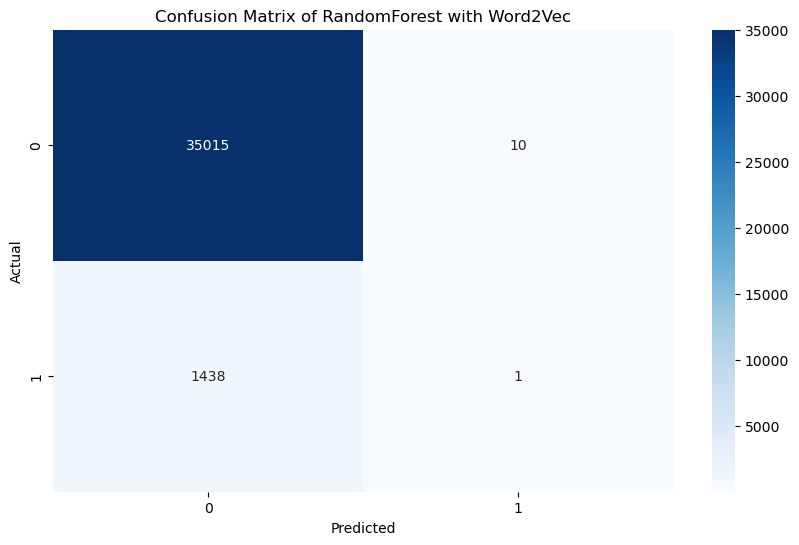

In [49]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix of RandomForest with Word2Vec')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()